In [1]:
from thesispy.experiments.wandb_client import *
from thesispy.definitions import *
from thesispy.plot_utils import *
from thesispy.elastix_wrapper.runner import run
from thesispy.elastix_wrapper.parameters import Parameters
from thesispy.experiments.instance import read_controlpoints, read_transform_params
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.image as mpimg
import numpy as np

In [7]:
moving_img = mpimg.imread(INSTANCES_SRC / "examples" / "scans" / "01_Moving.png")
fixed_img = mpimg.imread(INSTANCES_SRC / "examples" / "scans" / "01_Fixed.png")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(moving_img, cmap="gray")
axes[0].set_title("Moving")
axes[0].axis("off")

axes[1].imshow(fixed_img, cmap="gray")
axes[1].set_title("Fixed")
axes[1].axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("trivial_registration.pdf", bbox_inches="tight")

In [5]:
params = Parameters.from_base(mesh_size=5).asgd().stopping_criteria(iterations=10000).instance(Collection.EXAMPLES, 1)
run_result = run(params, Path("output/" + str(params)), suppress_stdout=False, visualize=False, validate=False)

2023-03-22 15:22:00,271 - Runner - INFO - Running elastix in: output/1679494920_examples_1_adaptivestochasticgradientdescent_266805



elastix is started at Wed Mar 22 15:22:00 2023.

which elastix:   /home/joasiee/Documents/projects/elastix/build/Release/bin/elastix
  elastix version: 5.1.0
  Git revision SHA: 1cff1b3d18524c335c762d292b8fc7051d897e8f
  Git revision date: Sun Mar 19 18:10:04 2023 +0100
  Build date: Mar 20 2023 17:36:10
  Compiler: GCC version 12.2.1 20230201
  Memory address size: 64-bit
  CMake version: 3.26.0
  ITK version: 5.3.0

Command-line arguments: 
  -p output/1679494920_examples_1_adaptivestochasticgradientdescent_266805/params_1.txt -f /home/joasiee/Documents/projects/instances/examples/scans/01_Fixed.png -m /home/joasiee/Documents/projects/instances/examples/scans/01_Moving.png -out output/1679494920_examples_1_adaptivestochasticgradientdescent_266805/out -threads 6

elastix runs at: archlinux
  Linux 6.1.20-1-lts (x64), #1 SMP PREEMPT_DYNAMIC Fri, 17 Mar 2023 13:31:00 +0000
  with 31842 MB memory, and 10 cores @ 800 MHz.
------------------------------------------------------------------

2023-03-22 15:22:01,318 - Runner - INFO - Run ended. It took 1.0474 seconds


9132	0.088438	70.437500	19.580000	2.091208	14.616000	0.002490	0.1
9133	0.088426	70.437500	19.570000	2.091724	14.617600	0.002437	0.1
9134	0.088413	70.437500	19.560000	2.092239	14.619200	0.002414	0.1
9135	0.088401	70.437500	19.550000	2.092755	14.620800	0.002403	0.1
9136	0.088389	70.437500	19.540000	2.093271	14.622400	0.002396	0.1
9137	0.088377	70.437500	19.530000	2.093788	14.624000	0.002392	0.1
9138	0.088365	70.437500	19.520000	2.094305	14.625600	0.002388	0.1
9139	0.088353	70.437500	19.510000	2.094822	14.627200	0.002385	0.1
9140	0.088341	70.437500	19.500000	2.095339	14.628800	0.002383	0.1
9141	0.088329	70.437500	19.490000	2.095856	14.630400	0.002380	0.1
9142	0.088320	70.437500	19.480000	2.096374	14.632000	0.019055	0.1
9143	0.088533	70.437500	19.470000	2.096892	14.633600	0.012864	0.1
9144	0.088325	70.437500	20.470000	2.046328	14.635200	0.004083	0.1
9145	0.088296	70.437500	20.460000	2.046822	14.636800	0.002996	0.2
9146	0.088279	70.437500	20.450000	2.047315	14.638400	0.002628	0.1
9147	0.088

In [12]:
from thesispy.experiments.validation import *

plt.figure(figsize=(7, 7))
plot_dvf(run_result.dvf, scale=5)
plt.savefig("trivial_dvf.pdf", bbox_inches="tight")

In [14]:
plt.figure(figsize=(7, 7))
plt.imshow(run_result.deformed, cmap="gray")
plt.axis("off")
plt.savefig("trivial_deformed.pdf", bbox_inches="tight")

In [16]:
iteration_output = np.loadtxt(Path("output") / "1679494920_examples_1_adaptivestochasticgradientdescent_266805" / "out" / "IterationInfo.0.R0.txt", skiprows=1)
missed_pixels = iteration_output[:, 2]

In [17]:
from thesispy.plot_utils import *

plt.figure(figsize=(7, 7))
plt.plot(missed_pixels)
plt.xlabel("Iteration")
plt.ylabel("Missed voxels (\%)")

plt.savefig("trivial_missedvoxels.pdf", bbox_inches="tight")

In [2]:
ds = get_runs_as_dataset("synthetic_1_constrained_selection")
ds.save()

In [3]:
arrs = ds.aggregate_for_plot(["UseConstraints", "MissedPixelConstraintThreshold"])
arrs_mp = ds.aggregate_for_plot(["UseConstraints", "MissedPixelConstraintThreshold"], metric="missedpixels")

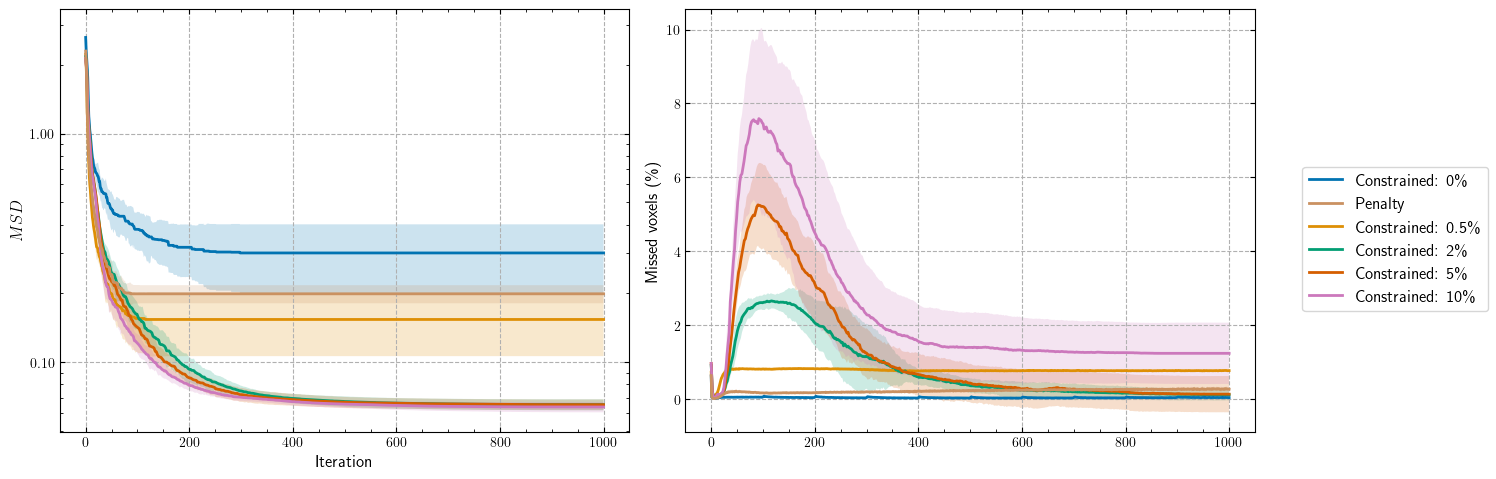

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(False)

for use_constraints in [True, False]:
    for i, constraints_threshold in enumerate([0, 0.5, 2, 5, 10]):
        if not use_constraints and i > 0:
            continue

        arr_avg, arr_median, arr_std = arrs[(use_constraints, constraints_threshold)]
        xs = np.linspace(0, 1000, len(arr_median))
        label = f"Constrained: {constraints_threshold}\%" if use_constraints else "Penalty"
        axes[0].plot(xs, arr_median, label=label)
        axes[0].fill_between(xs, arr_median - arr_std, arr_median + arr_std, alpha=0.2)

        arr_avg, arr_median, arr_std = arrs_mp[(use_constraints, constraints_threshold)]
        xs = np.linspace(0, 1000, len(arr_median))
        axes[1].plot(xs, arr_median, label=label)
        axes[1].fill_between(xs, arr_median - arr_std, arr_median + arr_std, alpha=0.2)
    
        # formatting
        axes[0].set_yscale("log")
        axes[0].yaxis.set_major_formatter(formatter)
        axes[0].set_xlabel("Iteration", fontsize=12)
        axes[0].set_ylabel("$MSD$", fontsize=12)
        axes[1].set_ylabel("Missed voxels (\%)", fontsize=12)


handles, labels = axes[0].get_legend_handles_labels()
order = [0, 5, 1, 2, 3, 4]
handles = [handles[i] for i in order]
labels = [labels[i] for i in order]
fig.legend(handles, labels, ncol=1, loc="center right", prop={'size': 12})
plt.tight_layout(rect=[0, 0.02, 0.85, 1])
# plt.savefig("constrained_selection_iterations.pdf")

In [ ]:
out_dir = Path('output/missed_pixels/out/')
files = [f for f in sorted((out_dir / "controlpoints.R0").iterdir(), key=lambda m: int(m.stem.split('.')[0])) if f.is_file()]
_, grid_spacing, grid_origin = read_transform_params(out_dir / 'TransformParameters.0.txt')

In [ ]:
def plot_cpoints(
    points,
    grid_spacing,
    grid_origin,
    alpha=0.8,
    color='red',
    plot_init=True,
    slice=None,
    ax=None,
):
    points_slice = points
    if len(points.shape) == 4:
        if slice is None:
            slice = points.shape[2] // 2
        points_slice = points[:, :, slice, :]

    grid_spacing = np.array(grid_spacing)
    grid_origin = np.array(grid_origin)

    grid_origin = grid_origin + 0.5
    X, Y = np.meshgrid(
        *[
            np.arange(
                grid_origin[i],
                grid_origin[i] + grid_spacing[i] * points_slice.shape[i],
                grid_spacing[i],
            )
            for i in range(len(points_slice.shape[:-1]))
        ]
    )

    colormap_colors = ["red", "green", "blue", "black"]
    cmap = LinearSegmentedColormap.from_list("quadrants", colormap_colors)

    colors = np.zeros(points_slice.shape[:-1])
    levels = int(np.ceil(points_slice.shape[0] / 2))
    for level in range(levels):
        level_color = (level+1) / levels
        max_index = points_slice.shape[0]-1-level
        colors[level, level:max_index+1] = level_color
        colors[max_index, level:max_index+1] = level_color
        colors[level:max_index+1, level] = level_color
        colors[level:max_index+1, max_index] = level_color

    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.gca()

    if plot_init:
        ax.scatter(Y, X, marker="+", c=colors, cmap=cmap, alpha=0.5, s=20)

    ax.grid(False)
    ax.scatter(
        points_slice[..., 0],
        points_slice[..., 1],
        marker="s",
        s=15,
        c=colors,
        cmap=cmap,
        alpha=alpha,
    )

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
plot_intervals = [0, 10, 100, 300]
n_intervals = len(plot_intervals)

for n, i in enumerate(plot_intervals):
    cpoints = read_controlpoints(files[i])
    plot_cpoints(cpoints, grid_spacing, grid_origin, ax=axes[n])
    axes[n].set_xticks([])
    axes[n].set_yticks([])
    axes[n].set_title(f"Generation = {i}", fontsize=14)
    axes[n].set_aspect('equal')

plt.tight_layout()
plt.savefig("missedpixels_controlpoints.pdf")

In [2]:
from thesispy.experiments.wandb_client import get_run_result

run_result_0 = get_run_result("synthetic_1_constrained_selection", "3hp1vybk")
run_result_10 = get_run_result("synthetic_1_constrained_selection", "y15mwrmb")

2023-03-16 12:56:23,050 - WandbClient - INFO - Retrieving run result from wandb: synthetic_1_constrained_selection/3hp1vybk
2023-03-16 12:56:25,913 - WandbClient - INFO - Retrieving run result from wandb: synthetic_1_constrained_selection/y15mwrmb


In [3]:
from thesispy.experiments.validation import plot_voxels, plot_dvf, get_vmin_vmax

clim_dvf, clim_jac = get_vmin_vmax(run_result_0, run_result_10)

2023-03-16 12:56:29,269 - Validation - INFO - Jacobian min,max: -0.1341476660895775, 6.709217035144078
2023-03-16 12:56:29,271 - Validation - INFO - Jacobian min,max: -1.830004321789985, 6.64560898184032


In [4]:
plot_dvf(run_result_0.dvf, vmin=clim_dvf[0], vmax=clim_dvf[1])
plt.savefig("dvf_c0.pdf", bbox_inches='tight')

In [5]:
plot_dvf(run_result_10.dvf, vmin=clim_dvf[0], vmax=clim_dvf[1])
plt.savefig("dvf_c10.pdf", bbox_inches='tight')

In [6]:
plot_voxels(run_result_0.deformed)
plt.savefig("voxels_constrained_0.pdf", bbox_inches='tight')

In [7]:
plot_voxels(run_result_10.deformed)
plt.savefig("voxels_constrained_10.pdf", bbox_inches='tight')